GPT ARCHITECTURE PART 1:  IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT

In [2]:
GPT_CONFIG_124M = {
    "vocab_size":50257,    # Vocabulary size
    "context_length":1024, # Context length
    "emb_dim":768,         # Embedding dimension
    "n_heads":12,          # Number of attention heads
    "n_layers":12,         # Number of layers
    "drop_rate":0.1,       # Dropout rate
    "qkv_bias":False       # Query-Key-Value bias
}

GPT ARCHITECTURE PART1 : DUMMY GPT MODEL CLASS

Step1 : Use a placeholder for Transformer block

Step2 : Use a placeholder for Layer Norm

In [3]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    #Use a placeholder transformer block
    self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    # Use a placeholder for Layer Norm
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)

  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    print(batch_size)
    print(seq_len)
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()

  def forward(self,x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self,cfg):
    super().__init__()

  def forward(self,x):
    return x



STEP1 : TOKENIZATION

In [4]:
import tiktoken
import torch
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


STEP2 : CREATE AN INSTANCE OF DUMMY GPT MODEL


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

2
4
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


GPT ARCHITECTURE PART 2: LAYER NORMALIZATION

In [6]:
import torch
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [7]:
mean = out.mean(dim=-1,keepdim=True)
print(mean)
var = out.var(dim=-1,keepdim=True)
print(var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [8]:
out_norm = (out - mean)/torch.sqrt(var)
print(out_norm)
mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
print(mean)
print(var)

torch.set_printoptions(sci_mode=False)
print(mean)
print(var)

tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)
tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [9]:
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var = x.var(dim=-1, keepdim=True,unbiased=False)
    norm_x = (x-mean)/torch.sqrt(var+self.eps) # eps added to avoid divide by zero error while normalizing
    return self.scale * norm_x + self.shift

In [10]:
ln = LayerNorm(emb_dim = 5)
print(batch_example)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1,keepdim=True)
var = out_ln.var(dim=-1,keepdim=True, unbiased=False)
print(mean)
print(var)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


GPT ARCHITECTURE PART 3: FEEDFORWARD NEURAL NETWORK WITH GELU

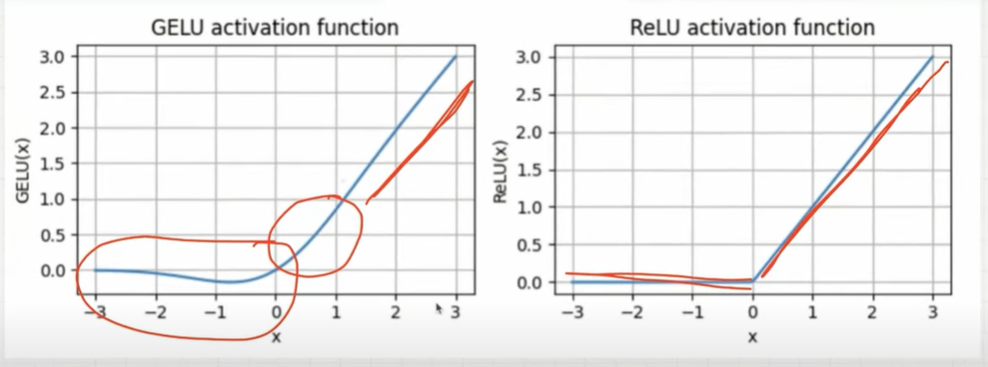

In [11]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+ torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*
                      (x + 0.044715 * torch.pow(x,3))))

tensor([-3.0000, -2.9394, -2.8788, -2.8182, -2.7576, -2.6970, -2.6364, -2.5758,
        -2.5152, -2.4545, -2.3939, -2.3333, -2.2727, -2.2121, -2.1515, -2.0909,
        -2.0303, -1.9697, -1.9091, -1.8485, -1.7879, -1.7273, -1.6667, -1.6061,
        -1.5455, -1.4848, -1.4242, -1.3636, -1.3030, -1.2424, -1.1818, -1.1212,
        -1.0606, -1.0000, -0.9394, -0.8788, -0.8182, -0.7576, -0.6970, -0.6364,
        -0.5758, -0.5152, -0.4545, -0.3939, -0.3333, -0.2727, -0.2121, -0.1515,
        -0.0909, -0.0303,  0.0303,  0.0909,  0.1515,  0.2121,  0.2727,  0.3333,
         0.3939,  0.4545,  0.5152,  0.5758,  0.6364,  0.6970,  0.7576,  0.8182,
         0.8788,  0.9394,  1.0000,  1.0606,  1.1212,  1.1818,  1.2424,  1.3030,
         1.3636,  1.4242,  1.4848,  1.5455,  1.6061,  1.6667,  1.7273,  1.7879,
         1.8485,  1.9091,  1.9697,  2.0303,  2.0909,  2.1515,  2.2121,  2.2727,
         2.3333,  2.3939,  2.4545,  2.5152,  2.5758,  2.6364,  2.6970,  2.7576,
         2.8182,  2.8788,  2.9394,  3.00

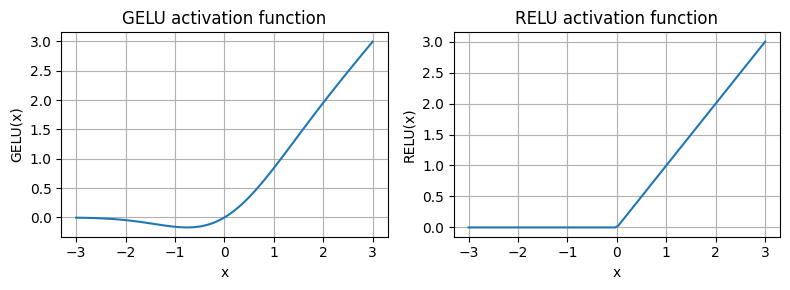

In [12]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3,3,100)
print(x)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,3))
for i , (y, label) in enumerate(zip([y_gelu,y_relu],["GELU","RELU"]),1):
  plt.subplot(1,2,i)
  plt.plot(x,y)
  plt.title(f"{label} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{label}(x)")
  plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
GPT_CONFIG_124M = {
    "vocab_size":50257,    # Vocabulary size
    "context_length":1024, # Context length
    "emb_dim":768,         # Embedding dimension
    "n_heads":12,          # Number of attention heads
    "n_layers":12,         # Number of layers
    "drop_rate":0.1,       # Dropout rate
    "qkv_bias":False       # Query-Key-Value bias
}

In [14]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4* cfg["emb_dim"]),
                                GELU(),
                                nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
    )

  def forward(self,x):
    return self.layers(x)

In [15]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768)
print(x)
out = ffn(x)
print(out)
print(out.shape)

tensor([[[0.0351, 0.0028, 0.6470,  ..., 0.5897, 0.8112, 0.1335],
         [0.2758, 0.6665, 0.3312,  ..., 0.7204, 0.3365, 0.9016],
         [0.7622, 0.4008, 0.4706,  ..., 0.4857, 0.9844, 0.0499]],

        [[0.8761, 0.8123, 0.2511,  ..., 0.8113, 0.3147, 0.6469],
         [0.9920, 0.7436, 0.7393,  ..., 0.8690, 0.1667, 0.4374],
         [0.8999, 0.0747, 0.1878,  ..., 0.0586, 0.7915, 0.8741]]])
tensor([[[ 0.1238,  0.0457,  0.0939,  ...,  0.1107,  0.0167, -0.1992],
         [ 0.1574, -0.0282,  0.0049,  ...,  0.0026,  0.1120, -0.1075],
         [ 0.1184, -0.0052,  0.0839,  ...,  0.1662,  0.0112, -0.1685]],

        [[ 0.1302,  0.0630,  0.1050,  ...,  0.1439,  0.0562, -0.1128],
         [ 0.1249, -0.0073,  0.1022,  ...,  0.0417,  0.0381, -0.0828],
         [ 0.0494,  0.0654,  0.0347,  ...,  0.0701,  0.0793, -0.1810]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 3, 768])


GPT ARCHITECTURE PART4 : SHORT CUT CONNECTIONS

In [16]:
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self,layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),GELU()),
    ])


  def forward(self,x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut and x.shape==layer_output.shape:
        x = x + layer_output
      else:
        x = layer_output
    return x


In [17]:
import torch
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.0,0.,-1.]])
torch.manual_seed(123)
model_wo_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [18]:
def print_gradients(model,x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output, target)
  loss.backward()

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [19]:
print_gradients(model_wo_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [20]:
import torch
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.0,0.,-1.]])
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)

In [21]:
print_gradients(model_with_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS

In [22]:
GPT_CONFIG_124M = {
    "vocab_size":50257,    # Vocabulary size
    "context_length":1024, # Context length
    "emb_dim":768,         # Embedding dimension
    "n_heads":12,          # Number of attention heads
    "n_layers":12,         # Number of layers
    "drop_rate":0.1,       # Dropout rate
    "qkv_bias":False       # Query-Key-Value bias
}

THE BUILDING BLOCKS : LAYER NORMALIZATION , GELU AND FEEDFORWARD

In [23]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean)/torch.sqrt(var+ self.eps)
    return self.scale * norm_x + self.shift

class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+ torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*
                      (x + 0.044715 * torch.pow(x,3))))

class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                                GELU(),
                                nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]))

  def forward(self,x):
    return self.layers(x)

Coding the transformer block

In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [25]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.attn = MultiHeadAttention(d_in = cfg["emb_dim"],
                                   d_out = cfg["emb_dim"],
                                   context_length = cfg["context_length"],
                                   num_heads = cfg["n_heads"],
                                   dropout = cfg["drop_rate"],
                                   qkv_bias = cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = shortcut + x

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = shortcut + x
    return x


In [26]:
torch.manual_seed(123)
x = torch.rand(2,4,768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:",x.shape)
print("Output shape:",output.shape)
print(output)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])
tensor([[[-0.0055,  0.0972, -0.1122,  ...,  1.2889,  0.2623,  0.6685],
         [ 0.0023, -0.2369,  0.1720,  ...,  0.5952,  0.2497,  0.7447],
         [ 0.4673,  0.4472,  0.1791,  ...,  1.2525,  0.3045,  0.7750],
         [ 0.0662,  0.7224,  0.9206,  ...,  0.4790,  0.7428,  0.7015]],

        [[ 0.3622,  1.2144,  0.5221,  ...,  0.1854,  0.0111, -0.5034],
         [-0.0225,  0.7789,  0.2770,  ...,  0.1734,  0.5419,  0.1143],
         [ 0.7425,  0.4013,  0.3211,  ...,  0.3268,  0.7523, -0.1642],
         [ 0.5745,  0.6241,  0.4410,  ...,  1.1963,  1.2650,  0.2243]]],
       grad_fn=<AddBackward0>)


PART6 : GPT ARCHITECTURE  

In [27]:
GPT_CONFIG_124M = {
    "vocab_size":50257,    # Vocabulary size
    "context_length":1024, # Context length
    "emb_dim":768,         # Embedding dimension
    "n_heads":12,          # Number of attention heads
    "n_layers":12,         # Number of layers
    "drop_rate":0.1,       # Dropout rate
    "qkv_bias":False       # Query-Key-Value bias
}

In [28]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    #Use a placeholder transformer block
    self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    # Use a placeholder for Layer Norm
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)

  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    print(batch_size)
    print(seq_len)
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()

  def forward(self,x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self,cfg):
    super().__init__()

  def forward(self,x):
    return x

In [29]:
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var = x.var(dim=-1, keepdim=True,unbiased=False)
    norm_x = (x-mean)/torch.sqrt(var+self.eps) # eps added to avoid divide by zero error while normalizing
    return self.scale * norm_x + self.shift


class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+ torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*
                      (x + 0.044715 * torch.pow(x,3))))

class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                                GELU(),
                                nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]))

  def forward(self,x):
    return self.layers(x)

In [30]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.attn = MultiHeadAttention(d_in = cfg["emb_dim"],
                                   d_out = cfg["emb_dim"],
                                   context_length = cfg["context_length"],
                                   num_heads = cfg["n_heads"],
                                   dropout = cfg["drop_rate"],
                                   qkv_bias = cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    shortcut = x
    x = self.norm1(x)
    x = self.attn(x)
    x = self.drop_shortcut(x)
    x = shortcut + x

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = shortcut + x
    return x

Entire GPT Architecture

In [31]:
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

  def forward(self,in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


In [32]:
import tiktoken
import torch
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n",batch)
print("Output shape",out.shape)
print(out)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [33]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters:{total_params}")

Total number of parameters:163009536


In [34]:
print("Token embedding layer shape",model.tok_emb.weight.shape)
print("Positional embedding layer shape",model.pos_emb.weight.shape)
print("Output layer shape",model.out_head.weight.shape)

Token embedding layer shape torch.Size([50257, 768])
Positional embedding layer shape torch.Size([1024, 768])
Output layer shape torch.Size([50257, 768])


In [35]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print("Number of trainable parameters considering weight trying" ,total_params_gpt2)

Number of trainable parameters considering weight trying 124412160


In [36]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"total size of the model:{total_size_mb:2f} MB")

total size of the model:621.832031 MB


GPT ARCHITECTURE PART 7: GENERATING TEXT FROM TOKENS

In [40]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    # Crop current context if it exceeds the supported context sixe
    # Ex if LLM Supports only 5 tokens, and the context size is 10 , then the last 5 tokens are used as context
    idx_cond = idx[:,-context_size:]
    print(idx_cond)

    with torch.no_grad():
      logits = model(idx_cond)
    logits = logits[:,-1,:] # taking the last token predictions for each batch in logits tensor.
    probas = torch.softmax(logits, dim=-1) # Redundant but gives additional intuition
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    idx = torch.cat((idx,idx_next),dim=1)
  return idx




In [ ]:
Sample example : "Hello , I am"

In [41]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:",encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:",encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


Put model into eval mode as we are not training, dropout shall be disabled.

In [42]:
model.eval()
out = generate_text_simple(model=model, idx=encoded_tensor,max_new_tokens=6, context_size=GPT_CONFIG_124M["context_length"])
print("Output:",out)
print("Output length:",len(out[0]))

tensor([[15496,    11,   314,   716]])
tensor([[15496,    11,   314,   716, 27018]])
tensor([[15496,    11,   314,   716, 27018, 24086]])
tensor([[15496,    11,   314,   716, 27018, 24086, 47843]])
tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961]])
tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348]])
Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [43]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
